In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt

from config import DSBConfig
import utils
from utils import DSBDataset
import mask_rcnn as modellib
import visualize
from mask_rcnn import log

Using TensorFlow backend.


In [2]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")


TRAIN_PATH = '../../dataset/DSB/train/'
TEST_PATH = '../../dataset/DSB/test/'

In [3]:
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [6]:
train_ids, val_ids = train_test_split(train_ids, test_size=0.1)

In [7]:
config = DSBConfig()
config.STEPS_PER_EPOCH  = len(train_ids)
config.VALIDATION_STEPS = len(val_ids)
config.display()


Configurations:
BACKBONE_SHAPES                [[96 96]
 [48 48]
 [24 24]
 [12 12]
 [ 6  6]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  384
IMAGE_MIN_DIM                  320
IMAGE_PADDING                  True
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           DSB
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000


In [8]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [9]:
# Training dataset
dataset_train = DSBDataset()
dataset_train.load_DSB(320, 320, train_ids, TRAIN_PATH)
dataset_train.prepare()

# Validation dataset
dataset_val = DSBDataset()
dataset_val.load_DSB(320, 320, val_ids, TRAIN_PATH)
dataset_val.prepare()

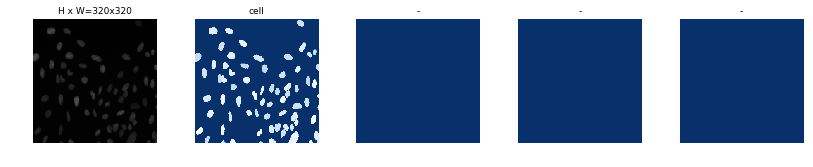

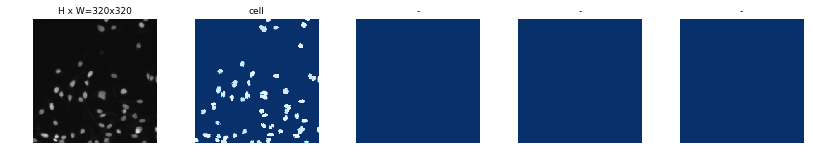

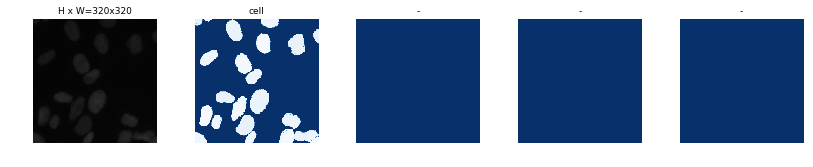

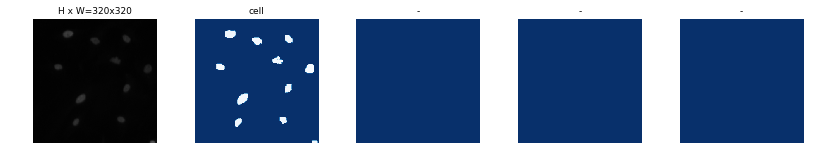

In [10]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [11]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [12]:
# Which weights to start with?
# imagenet, coco, or last
init_with = "coco"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [13]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /root/work/segmentation/mask-rcnn/logs/dsb20180308T1601/mask_rcnn_dsb_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcn

/root/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/root/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
603/603 [==============================] - 885s 1s/step - loss: 2.0401 - rpn_class_loss: 0.1638 - rpn_bbox_loss: 1.2656 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.2548 - mrcnn_mask_loss: 0.2820 - val_loss: 1.7249 - val_rpn_class_loss: 0.0836 - val_rpn_bbox_loss: 1.0995 - val_mrcnn_class_loss: 0.0665 - val_mrcnn_bbox_loss: 0.2278 - val_mrcnn_mask_loss: 0.2475

In [14]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(
    dataset_train,
    dataset_val, 
    learning_rate=config.LEARNING_RATE / 10,
    epochs=2, 
    layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /root/work/segmentation/mask-rcnn/logs/dsb20180308T1601/mask_rcnn_dsb_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3

/root/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/root/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 2/2
603/603 [==============================] - 946s 2s/step - loss: 1.6735 - rpn_class_loss: 0.0886 - rpn_bbox_loss: 1.0508 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.1875 - mrcnn_mask_loss: 0.2492 - val_loss: 1.9931 - val_rpn_class_loss: 0.0949 - val_rpn_bbox_loss: 1.1489 - val_mrcnn_class_loss: 0.1052 - val_mrcnn_bbox_loss: 0.2834 - val_mrcnn_mask_loss: 0.3606

In [15]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
#model_path = os.path.join(MODEL_DIR, "mask_rcnn_DSB.h5")
#model.keras_model.save_weights(model_path)

In [16]:
class InferenceConfig(DSBConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(
    mode="inference", 
    config=inference_config,
    model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /root/work/segmentation/mask-rcnn/logs/dsb20180308T1601/mask_rcnn_dsb_0002.h5


original_image           shape: (384, 384, 3)         min:    0.00000  max:  211.81250
image_meta               shape: (10,)                 min:    1.00000  max:  352.00000
gt_class_id              shape: (111,)                min:    1.00000  max:    1.00000
gt_bbox                  shape: (111, 4)              min:   32.00000  max:  352.00000
gt_mask                  shape: (384, 384, 111)       min:    0.00000  max:  255.00000


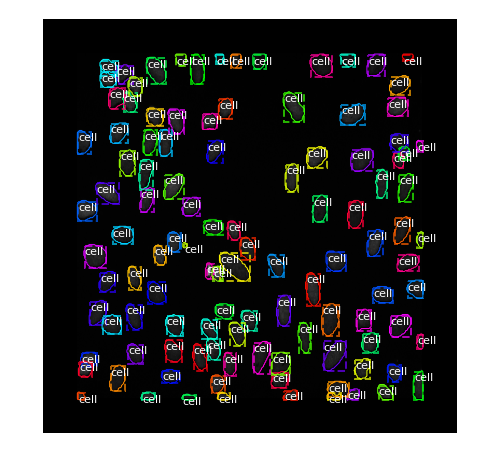

In [37]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(
    dataset_val,
    inference_config, 
    image_id,
    use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(
    original_image,
    gt_bbox,
    gt_mask,
    gt_class_id, 
    dataset_train.class_names,
    figsize=(8, 8))

Processing 1 images
image                    shape: (384, 384, 3)         min:    0.00000  max:  211.81250
molded_images            shape: (1, 384, 384, 3)      min: -123.70000  max:  107.91250
image_metas              shape: (1, 10)               min:    0.00000  max:  384.00000


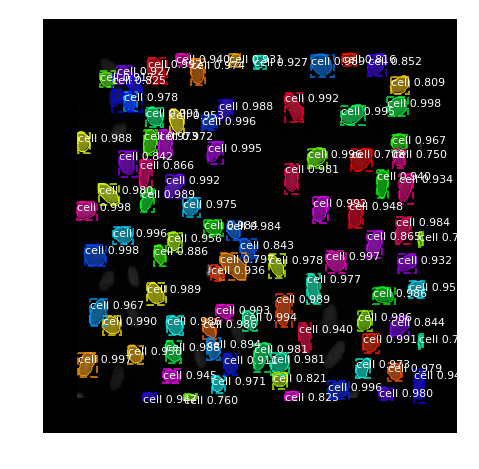

In [38]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(
    original_image,
    r['rois'],
    r['masks'],
    r['class_ids'], 
    dataset_val.class_names,
    r['scores'],
    ax=get_ax())

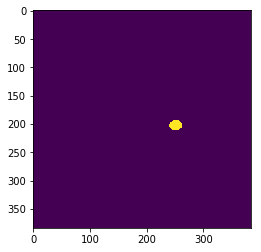

In [30]:
%matplotlib inline
plt.imshow(results[0]["masks"][:, :, 30])

In [32]:
np.unique(original_image)

array([   0.  ,    9.  ,    9.09, ...,  209.01,  210.5 ,  212.29])